# Training Diffusion Models

This Jupyter notebook trains a Stable Diffusion model to generate chest X-ray image of normal lungs and COVID-19-positive lungs.

The dataset used in this tutorial can be found here: https://www.kaggle.com/datasets/ankitachoudhury01/covid-patients-chest-xray

The training technique is DreamBooth which trains text encoder and diffusion model.


About DreamBooth: https://dreambooth.github.io/


Code modified from: https://github.com/huggingface/diffusers/blob/main/examples/dreambooth/train_dreambooth.py

## Install & Import

In [ ]:
!python --version

Python 3.10.12


In [ ]:
!pip install -U -qq git+https://github.com/huggingface/diffusers.git
!pip install accelerate transformers ftfy
!pip install bitsandbytes
!pip install tensorboard

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
#@title Import Required Libraries
import argparse
import hashlib
import itertools
import random
import json
import math
import os
from pathlib import Path
from typing import Optional

import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch.utils.data import Dataset

from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
from diffusers import AutoencoderKL, DDIMScheduler, DDPMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.optimization import get_scheduler
from huggingface_hub import HfFolder, Repository, whoami
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer


torch.backends.cudnn.benchmark = True

## Dataset & Functions

In [ ]:
!gdown 1zspf9Z3x3lhqb_1p6U79D1eZcXuwmGXh

Downloading...
From: https://drive.google.com/uc?id=1zspf9Z3x3lhqb_1p6U79D1eZcXuwmGXh
To: /content/normal_covid.zip
100% 5.92M/5.92M [00:00<00:00, 188MB/s]


In [ ]:
!unzip normal_covid.zip

Archive:  normal_covid.zip
replace COVID PATIENTS/COVID/covid_0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
normal_files = [f"/content/NORMAL PATIENTS/NORMAL/normal_{i}.jpg" for i in range(162)]
covid_files = [f"/content/COVID PATIENTS/COVID/covid_{i}.jpg" for i in range(162)]
df = pd.DataFrame({"Image Path":normal_files + covid_files, "Label":[0]*162 + [1]*162})

In [ ]:
df_samp = pd.concat([df.iloc[:162].sample(27, random_state=42), df.iloc[162:].sample(27, random_state=42)])

In [ ]:
prompts = {
    0: "normal healthy lungs: clear lung fields, both the left and right lung fields appear clear and well-defined without any visible abnormalities, \
    the lungs are symmetrical in shape and size, with no evidence of asymmetry or distortion, \
    the size and shape of the heart are within the normal range, with clear borders, \
    the ribs and rib cage appear normal, without any fractures, deformities, or abnormalities",
    1: "COVID-19 positive lungs: bilateral ground glass opacities, hazy or cloudy areas in the lung tissue on both sides of the chest, \
    consolidation appears as white, dense areas in the lung tissue, filling of airspaces with fluid, inflammatory cells, or debris"
}

In [ ]:
class ChestXDataset(Dataset):
    """
    A dataset to prepare the instance and class images with the prompts for fine-tuning the model.
    It pre-processes the images and the tokenizes prompts.
    """

    def __init__(
        self,
        df,
        tokenizer,
        size=512,
        center_crop=False,
        pad_tokens=False,
        hflip=False
    ):
        self.size = size
        self.center_crop = center_crop
        self.tokenizer = tokenizer
        self.pad_tokens = pad_tokens
        self.df = df

        self._length = len(df)

        self.image_transforms = transforms.Compose(
            [
                transforms.RandomHorizontalFlip(0.5 * hflip),
                transforms.Resize((size,size), interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )

    def __len__(self):
        return self._length

    def __getitem__(self, idx):
        example = {}
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image_path = self.df.iloc[idx]['Image Path']
        image = Image.open(image_path)
        label = self.df.iloc[idx]['Label']
        prompt = prompts[label]
        if not image.mode == "RGB":
            image = image.convert("RGB")
        example["images"] = self.image_transforms(image)
        example["prompt_ids"] = self.tokenizer(
            prompt,
            padding="max_length" if self.pad_tokens else "do_not_pad",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
        ).input_ids

        return example

In [ ]:
class PromptDataset(Dataset):
    "A simple dataset to prepare the prompts to generate class images on multiple GPUs."

    def __init__(self, prompt, num_samples):
        self.prompt = prompt
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, index):
        example = {}
        example["prompt"] = self.prompt
        example["index"] = index
        return example

In [ ]:
class LatentsDataset(Dataset):
    def __init__(self, latents_cache, text_encoder_cache):
        self.latents_cache = latents_cache
        self.text_encoder_cache = text_encoder_cache

    def __len__(self):
        return len(self.latents_cache)

    def __getitem__(self, index):
        return self.latents_cache[index], self.text_encoder_cache[index]

In [ ]:
class AverageMeter:
    def __init__(self, name=None):
        self.name = name
        self.reset()

    def reset(self):
        self.sum = self.count = self.avg = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
pretrained_model_name_or_path = "runwayml/stable-diffusion-v1-5"

## Sample Image

### Normal

In [ ]:
samp_img = Image.open(df_samp.iloc[0]["Image Path"])

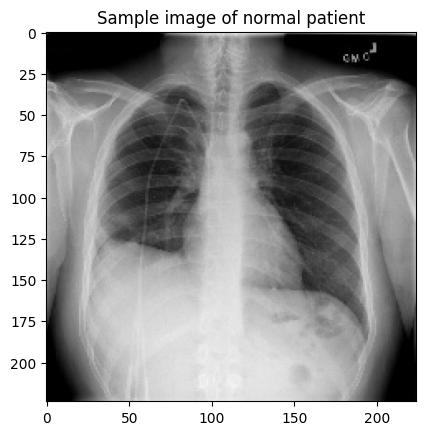

In [ ]:
plt.title("Sample image of normal patient")
plt.imshow(samp_img)
plt.show()

In [ ]:
samp_img2 = Image.open(df_samp.iloc[-1]["Image Path"])

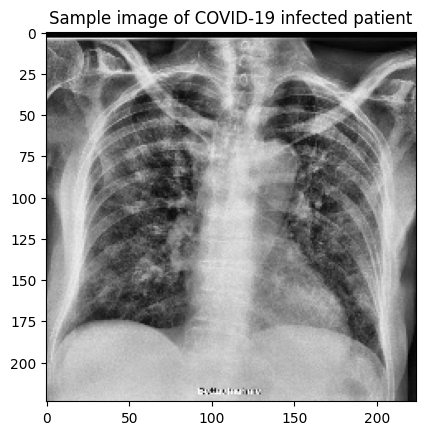

In [ ]:
plt.title("Sample image of COVID-19 infected patient")
plt.imshow(samp_img2)
plt.show()

In [ ]:
samp_img.size

(224, 224)

## Prepare Models

Training Arguments:

```
learning_rate: Initial learning rate (after the potential warmup period) to use.
Seed: A seed for reproducible training.
train_text_encoder: Whether to train the text encoder (freezed if false)
gradient_accumulation_steps: Number of updates steps to accumulate before performing a backward/update pass.
mixed_precision: Whether to use mixed precision (between fp16 and bf16)
gradient_checkpointing: Whether or not to use gradient checkpointing to save memory at the expense of slower backward pass.
scale_lr: Scale the learning rate by the number of GPUs, gradient accumulation steps, and batch size.
train_batch_size: Batch size (per device) for the training dataloader
adam_beta1: The beta1 parameter for the Adam optimizer.
adam_beta2: The beta2 parameter for the Adam optimizer.
adam_weight_decay: Weight decay to use.
adam_epsilon: Epsilon value for the Adam optimizer.

```



In [ ]:
class Args():
    def __init__(self):
      self.learning_rate = 2e-06
      self.seed = 42
      self.train_text_encoder = True
      self.gradient_accumulation_steps = 1
      self.mixed_precision = "no"
      self.gradient_checkpointing = True
      self.scale_lr = True
      self.train_batch_size = 1
      self.adam_beta1 = 0.9
      self.adam_beta2 = 0.999
      self.adam_weight_decay = 1e-02
      self.adam_epsilon = 1e-08
      self.hflip = False
      self.resolution = 224
      self.center_crop = False
      self.pad_tokens = False
      self.max_train_steps = None
      self.num_train_epochs = 5
      self.lr_scheduler = "constant"
      self.output_dir = "/content/"
      self.lr_warmup_steps = 500
      self.max_grad_norm = 5
      self.not_cache_latents = True

args = Args()

In [ ]:
accelerator = Accelerator(
    gradient_accumulation_steps=args.gradient_accumulation_steps,
    mixed_precision=args.mixed_precision,
    log_with="tensorboard",
    project_dir="logs",
)

In [ ]:
tokenizer = CLIPTokenizer.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="tokenizer",
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# Load models and create wrapper for stable diffusion
text_encoder = CLIPTextModel.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="text_encoder",
    # revision=None,
)
vae = AutoencoderKL.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="vae",
    revision=None
)
unet = UNet2DConditionModel.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="unet",
    torch_dtype=torch.float32,
    revision=None
)

vae.requires_grad_(False);

## Before Training

In [ ]:
# @title Pipeline
from diffusers import StableDiffusionPipeline
device = torch.device("cuda")
text_encoder = text_encoder.to(device)
vae = vae.to(device)
unet = unet.to(device)

pipe = StableDiffusionPipeline.from_pretrained(
    pretrained_model_name_or_path,
    tokenizer=tokenizer,
    text_encoder=text_encoder,
    vae=vae,
    unet=unet
).to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

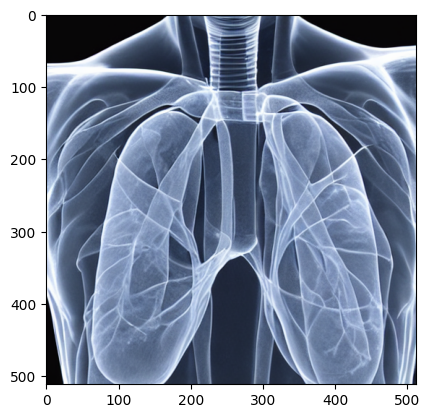

In [ ]:
# @title NORMAL
prompt = "chest X-ray image of normal healthy lungs"
w, h = (512, 512)
generator = torch.Generator()
generator.manual_seed(111)
latents = torch.randn((1, 4, w//8, h//8)).to(device)
img = pipe(prompt=prompt, width=w, height=h, latents=latents).images[0]
plt.imshow(img)
plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

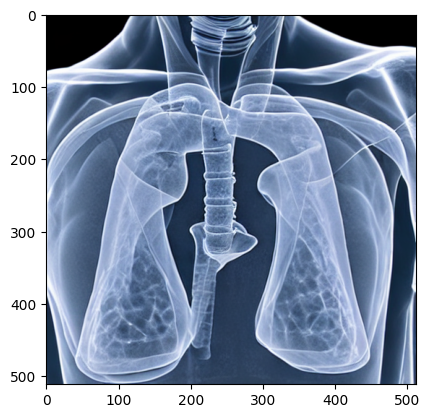

In [ ]:
# @title COVID
prompt = "chest X-ray image of COVID-19 positive lungs"
img = pipe(prompt=prompt, width=w, height=h, latents=latents).images[0]
plt.imshow(img)
plt.show()

## Prepare for training

In [ ]:
if not args.train_text_encoder:
    text_encoder.requires_grad_(False)

if args.gradient_checkpointing:
    unet.enable_gradient_checkpointing()
    if args.train_text_encoder:
        text_encoder.gradient_checkpointing_enable()


if args.scale_lr:
    args.learning_rate = (
        args.learning_rate * args.gradient_accumulation_steps * args.train_batch_size * accelerator.num_processes
    )

import bitsandbytes as bnb

optimizer_class = bnb.optim.AdamW8bit

params_to_optimize = (
    itertools.chain(unet.parameters(), text_encoder.parameters()) if args.train_text_encoder else unet.parameters()
)
optimizer = optimizer_class(
    params_to_optimize,
    lr=args.learning_rate,
    betas=(args.adam_beta1, args.adam_beta2),
    weight_decay=args.adam_weight_decay,
    eps=args.adam_epsilon,
)

noise_scheduler = DDPMScheduler.from_pretrained(pretrained_model_name_or_path, subfolder="scheduler")

train_dataset = ChestXDataset(
    df=df_samp,
    tokenizer=tokenizer,
    size=args.resolution,
    center_crop=args.center_crop,
    pad_tokens=args.pad_tokens,
    hflip=args.hflip
)

In [ ]:
def collate_fn(examples):
    input_ids = [example["prompt_ids"] for example in examples]
    pixel_values = [example["images"] for example in examples]

    # Concat class and instance examples for prior preservation.
    # We do this to avoid doing two forward passes.

    pixel_values = torch.stack(pixel_values)
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

    input_ids = tokenizer.pad(
        {"input_ids": input_ids},
        padding=True,
        return_tensors="pt",
    ).input_ids

    batch = {
        "input_ids": input_ids,
        "pixel_values": pixel_values,
    }
    return batch

In [ ]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=args.train_batch_size, shuffle=True, collate_fn=collate_fn, pin_memory=True
)


weight_dtype = torch.float32
if args.mixed_precision == "fp16":
    weight_dtype = torch.float16
elif args.mixed_precision == "bf16":
    weight_dtype = torch.bfloat16

vae.to(accelerator.device, dtype=weight_dtype)
if not args.train_text_encoder:
  text_encoder.to(accelerator.device, dtype=weight_dtype)

In [ ]:
# Scheduler and math around the number of training steps.
overrode_max_train_steps = False
num_update_steps_per_epoch = math.ceil(len(train_dataloader) / args.gradient_accumulation_steps)
if args.max_train_steps is None:
    args.max_train_steps = args.num_train_epochs * num_update_steps_per_epoch
    overrode_max_train_steps = True

lr_scheduler = get_scheduler(
    args.lr_scheduler,
    optimizer=optimizer,
    num_warmup_steps=args.lr_warmup_steps * args.gradient_accumulation_steps,
    num_training_steps=args.max_train_steps * args.gradient_accumulation_steps,
)

if args.train_text_encoder:
    unet, text_encoder, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        unet, text_encoder, optimizer, train_dataloader, lr_scheduler
    )
else:
    unet, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        unet, optimizer, train_dataloader, lr_scheduler
    )

# We need to recalculate our total training steps as the size of the training dataloader may have changed.
num_update_steps_per_epoch = math.ceil(len(train_dataloader) / args.gradient_accumulation_steps)
if overrode_max_train_steps:
    args.max_train_steps = args.num_train_epochs * num_update_steps_per_epoch
# Afterwards we recalculate our number of training epochs
args.num_train_epochs = math.ceil(args.max_train_steps / num_update_steps_per_epoch)

# We need to initialize the trackers we use, and also store our configuration.
# The trackers initializes automatically on the main process.
if accelerator.is_main_process:
    accelerator.init_trackers("dreambooth")

# Train!
total_batch_size = args.train_batch_size * accelerator.num_processes * args.gradient_accumulation_steps

print("***** Running training *****")
print(f"  Num examples = {len(train_dataset)}")
print(f"  Num batches each epoch = {len(train_dataloader)}")
print(f"  Num Epochs = {args.num_train_epochs}")
print(f"  Instantaneous batch size per device = {args.train_batch_size}")
print(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
print(f"  Gradient Accumulation steps = {args.gradient_accumulation_steps}")
print(f"  Total optimization steps = {args.max_train_steps}")

***** Running training *****
  Num examples = 54
  Num batches each epoch = 54
  Num Epochs = 5
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 270


In [ ]:
def save_weights(step):
    # Create the pipeline using using the trained modules and save it.
    if accelerator.is_main_process:
        if args.train_text_encoder:
            text_enc_model = accelerator.unwrap_model(text_encoder)
        else:
            text_enc_model = CLIPTextModel.from_pretrained(pretrained_model_name_or_path, subfolder="text_encoder", revision=None)
        scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)
        pipeline = StableDiffusionPipeline.from_pretrained(
            pretrained_model_name_or_path,
            unet=accelerator.unwrap_model(unet),
            text_encoder=text_enc_model,
            vae=AutoencoderKL.from_pretrained(
                pretrained_model_name_or_path,
                subfolder="vae",
            ),
            safety_checker=None,
            scheduler=scheduler,
            torch_dtype=torch.float16,
            revision=None,
        )
        save_dir = os.path.join(args.output_dir, f"{step}")
        pipeline.save_pretrained(save_dir)
        with open(os.path.join(save_dir, "args.json"), "w") as f:
            json.dump(args.__dict__, f, indent=2)

        print(f"[*] Weights saved at {save_dir}")

## Begin Training (approx. 3 min)

In [ ]:
from tqdm import tqdm
from datetime import datetime
# Only show the progress bar once on each machine.
# progress_bar = tqdm(range(args["max_train_steps"]), disable=not accelerator.is_local_main_process)
# progress_bar.set_description("Steps")
global_step = 0
loss_avg = AverageMeter()
# text_enc_context = nullcontext() if args["train_text_encoder"] else torch.no_grad()
from IPython.display import display, clear_output

start = datetime.now()
for epoch in range(args.num_train_epochs):
    unet.train()
    if args.train_text_encoder:
        text_encoder.train()
    for step, batch in enumerate(train_dataloader):
        batch["pixel_values"] = batch["pixel_values"].to(device)
        batch["input_ids"] = batch["input_ids"].to(device)
        with accelerator.accumulate(unet):
            # Convert images to latent space
            with torch.no_grad():
                latent_dist = vae.encode(batch["pixel_values"].to(dtype=weight_dtype)).latent_dist
                latents = latent_dist.sample().detach() * 0.18215

            # Sample noise that we'll add to the latents
            noise = torch.randn_like(latents)
            bsz = latents.shape[0]
            # Sample a random timestep for each image
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device)
            timesteps = timesteps.long()

            # Add noise to the latents according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

            # Get the text embedding for conditioning
            encoder_hidden_states = text_encoder(batch["input_ids"])[0]

            # Predict the noise residual
            noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

            loss = F.mse_loss(noise_pred.float(), noise.float(), reduction="mean")

            accelerator.backward(loss)
            if accelerator.sync_gradients:
                params_to_clip = (
                    itertools.chain(unet.parameters(), text_encoder.parameters())
                    if args.train_text_encoder
                    else unet.parameters()
                )
                accelerator.clip_grad_norm_(params_to_clip, args.max_grad_norm)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad(set_to_none=True)
            loss_avg.update(loss.detach_(), bsz)




        clear_output(wait=True)
        display('Iteration '+str(global_step+1)+'/'+str(args.max_train_steps)+' Loss: '+str(loss.item()))

        global_step += 1

        if global_step >= args.max_train_steps:
            break

    accelerator.wait_for_everyone()


accelerator.end_training()
end = datetime.now()

'Iteration 270/270 Loss: 0.1140575185418129'

In [ ]:
elapsed = (end - start).seconds
print(f"{elapsed//60} min, {elapsed%60} seconds elapsed")

2 min, 52 seconds elapsed


In [ ]:
unet = accelerator.unwrap_model(unet)
accelerator.save(unet.state_dict(), "unet_chestx.pt")
text_encoder = accelerator.unwrap_model(text_encoder)
accelerator.save(text_encoder.state_dict(), "text_encoder_chestx.pt")

In [ ]:
unet.load_state_dict(torch.load("unet_chestx.pt"))
text_encoder.load_state_dict(torch.load("text_encoder_chestx.pt"))

<All keys matched successfully>

## After Training

In [ ]:
# @title Pipeline
unet.eval()
text_encoder.eval()
pipe = StableDiffusionPipeline.from_pretrained(
    pretrained_model_name_or_path,
    tokenizer=tokenizer,
    text_encoder=text_encoder,
    unet=unet,
    torch_dtype=torch.float32
).to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

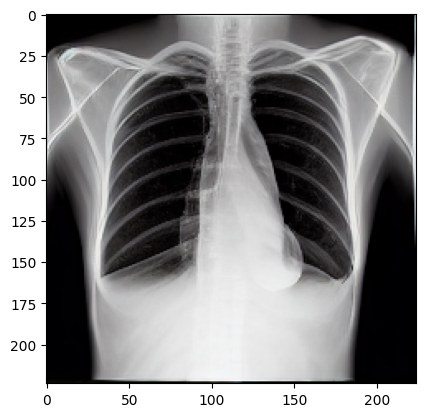

In [ ]:
# @title NORMAL
prompt = "chest X-ray image of normal healthy lungs"
w, h = (224, 224)
generator = torch.Generator()
generator.manual_seed(42)
latents = torch.randn((1, 4, w//8, h//8)).to(device)
img = pipe(prompt=prompt, width=w, height=h, latents=latents).images[0]
plt.imshow(img)
plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

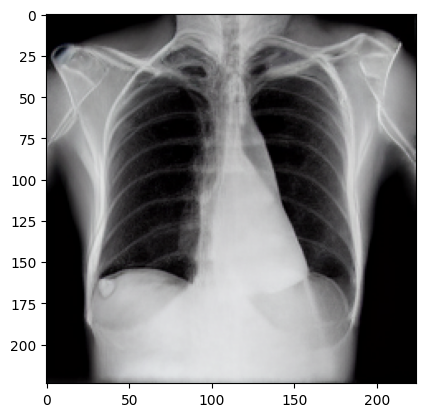

In [ ]:
# @title COVID
prompt = "chest X-ray image of COVID-19 positive lungs"
img = pipe(prompt=prompt, width=w, height=h, latents=latents).images[0]
plt.imshow(img)
plt.show()